# Please use the below link to view my file on github as github can not render folium maps

https://nbviewer.jupyter.org/github/hovanhuang/Data-Science-Project/blob/master/Final%20Capstone%20Project.ipynb

### 1. Preparation

 - Import all necessary liberaries
 - Input Foursquare Client ID and Client Secret'

In [1]:
import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
import random # library for random number generation
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values
import folium # plotting library
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize
from itertools import permutations
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import euclidean_distances
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline 

In [2]:
CLIENT_ID = 'K1QQ31GDDLSAXRJ2RCDI134XGVE5G0WNA0H1XW3TZOXV4VGS' # your Foursquare ID
CLIENT_SECRET = 'SO3ADVRZ540GGKK5VI3O4VDTLAXBHDEDLXX0JQXX0KNKTEM5' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 100
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: K1QQ31GDDLSAXRJ2RCDI134XGVE5G0WNA0H1XW3TZOXV4VGS
CLIENT_SECRET:SO3ADVRZ540GGKK5VI3O4VDTLAXBHDEDLXX0JQXX0KNKTEM5


### 2. Data Acquiring
Create a function that could use coordinate and search criteria as input, and outputs a dataframe contains results.

In [3]:
  # function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']

    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']
    
def get_venue_df (Latitude, Longtitude, radius, search_query):
    url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, Latitude, Longtitude, VERSION, search_query, radius, LIMIT)
    results = requests.get(url).json()
    venues = results['response']['venues']
    dataframe = json_normalize(venues)
    
    # filter the category for each row
    dataframe['categories'] = dataframe.apply(get_category_type, axis=1)
    # clean column names by keeping only last term
    dataframe.columns = [column.split('.')[-1] for column in dataframe.columns]
    # keep only columns that include venue name, and anything that is associated with location
    dataframe = dataframe[['id', 'name', 'categories', 'lat', 'lng']]
    # Drop columns with NaN values
    dataframe.categories = dataframe['categories'].fillna('HHFILL')
    dataframe.dropna(axis = 'columns', inplace=True)
    return dataframe

The project is about to explore the venue and analysis around the Houston, TX area so get location of the city center.

In [5]:
address = 'Houston, TX'
geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
Hou_cen_latitude = location.latitude
Hou_cen_longitude = location.longitude
print(Hou_cen_latitude, Hou_cen_longitude)

29.7589382 -95.3676974


The FourSquare API only allow maximum results of 50 for each regular call. We want to explore as more resteraunt as possible, thus we make multiple calls from multiple geographic locations and assemble our resteraunt list afterwards. From the center of Houston TX, we create a latitude/longitude grid search points.

In [6]:
lat_range = np.linspace (Hou_cen_latitude-0.10, Hou_cen_latitude+0.05, num = 8)
lng_range = np.linspace (Hou_cen_longitude-0.10, Hou_cen_longitude+0.05, num = 8)
i = 0
for hou_lat in lat_range:
    for hou_lng in lng_range:
        Houston_food = get_venue_df(hou_lat, hou_lng, 3000, 'food')
        if i == 0:
             Houston_food_total = Houston_food
        Houston_food_total = pd.concat([Houston_food, Houston_food_total])
        i=+1
        # In case the grid search ending up with duplicates, remove all the duplicate search results
Houston_food_total.drop_duplicates(subset = 'id', inplace = True)

Review the search results and parse the data we acquired. Before using the data, we need to elimination some of the irrelevant results, e.g. categories thats not related to the resteraunt such as "gas stations", "buildings" etc.

In [7]:
Houston_food_filtered=Houston_food_total[~Houston_food_total.categories.isin(['Convenience Store','HHFILL','Building','Gas Station','Convenience Store','Supermarket','Financial or Legal Service', 'Grocery Store', 'Mobile Phone Shop', 'Market', 'Coworking Space'])]
print('Theres', Houston_food_filtered.shape[0], 'resteraunts in the grid search')
Houston_food_filtered.head(10)

Theres 262 resteraunts in the grid search


,id,name,categories,lat,lng
2,5b82fb81123a19002c4cd06b,Heavenly Choices Soul Food,Southern / Soul Food Restaurant,29.799557,-95.332985
8,534aa891498eb5bc1146720f,Helen T's Soul Food Cafe',Café,29.830334,-95.319173
11,4f32599619836c91c7cf1297,King's Tasty Foods,Food,29.813857,-95.317654
14,5ade261993bd637585162402,El Venado Foods,Food Service,29.803803,-95.340890
7,4f324cb519836c91c7ca12c9,Casa Blanca Mexican Food,Food,29.798847,-95.354043
9,51ad5e76498e5b6d8d38658a,Betton's Comfort Food,Food Truck,29.793639,-95.351498
17,4f32350019836c91c7c0b5da,P and P Food Mart,Food,29.781860,-95.332881
2,5a91e1ed2c7eb9116f8b08b5,Fuego Food,Food Truck,29.819747,-95.386714
5,5aeb9702e55d8b002cb25478,Street Food Thai Market,Thai Restaurant,29.804116,-95.385142
9,536bb7b7498e99c3ef0a2820,Lana's Fast Food,Chinese Restaurant,29.804083,-95.377784


Otherthan resteraunts, we need to get the location information of places which we speculated as hub of resteraunts in our proposition. Let's pick grocery shops, shopping malls and cinemas.

In [8]:
# Get groceries stores within 20km of center of Houston.
Houston_SuperM1 = get_venue_df(Hou_cen_latitude, Hou_cen_longitude, 10000, 'Grocery')
Houston_SuperM2 = get_venue_df(Hou_cen_latitude, Hou_cen_longitude, 10000, 'Market')
Houston_SuperM = pd.concat([Houston_SuperM1,Houston_SuperM2])
Houston_SuperM = Houston_SuperM[Houston_SuperM.name.str.contains('H-E-B|Kroger|Whole')]
Houston_SuperM

,id,name,categories,lat,lng
4,5e3b4b2f9b92a90008cbfb35,H-E-B Curbside Pickup & Grocery Delivery,Grocery Store,29.768968,-95.396583
6,5e00dc17898a6a000861fb1b,H-E-B Curbside Pickup & Grocery Delivery,Grocery Store,29.714046,-95.377260
8,59dc14196fa81f4616cc9aa1,H-E-B Curbside Pickup & Grocery Delivery,Grocery Store,29.738034,-95.402704
13,5e3ad71c57fcde0008a94157,H-E-B Curbside Pickup & Grocery Delivery,Grocery Store,29.726999,-95.427071
16,5b802d6fbd4009002c144081,H-E-B Curbside Pickup & Grocery Delivery,Grocery Store,29.707609,-95.468950
18,5e382f3b0d366a000803ca9d,H-E-B Curbside Pickup & Grocery Delivery,Grocery Store,29.688878,-95.464268
25,5c48863ef62e09002c7ef750,The Heights H-E-B,Grocery Store,29.807098,-95.409275
29,5d15b7e31822230026f11900,Kroger Grocery Pickup and Delivery,Grocery Store,29.804629,-95.400582
33,5e5eb9809f640c0007d027e4,H-E-B Curbside Pickup & Grocery Delivery,Grocery Store,29.807351,-95.408957
1,4db85cbef7b15ca52ce8b875,Whole Foods Market,Grocery Store,29.757994,-95.397643


In [9]:
# Get cinemas within 20km of center of Houston.
Houston_cinema =  get_venue_df(Hou_cen_latitude, Hou_cen_longitude, 10000, 'cinema')
Houston_cinema = Houston_cinema[Houston_cinema.name.str.contains('Cinemark|Regal|AMC')]
Houston_cinema

,id,name,categories,lat,lng
7,4b3feb8af964a52013b225e3,Regal Edwards Greenway Grand Palace ScreenX & RPX,Movie Theater,29.730839,-95.440551
8,4a9045c1f964a520f31620e3,Cinemark,Movie Theater,29.768997,-95.229342
9,465978f4f964a5201b471fe3,"Regal Edwards Houston Marq*E Screenx, 4DX, IMA...",Movie Theater,29.785704,-95.463748


In [10]:
# Get Shopping Malls within 20km of center of Houston.
Houston_shop = get_venue_df(Hou_cen_latitude, Hou_cen_longitude, 12000, 'shopping')
Houston_shop = Houston_shop[Houston_shop.categories == 'Shopping Mall']
Houston_shop

,id,name,categories,lat,lng
1,4e04fb3eb61cf74861301723,River Oaks Shopping Center,Shopping Mall,29.753011,-95.409400
3,50b3d9d9e4b0036cfc3b9d46,West University Shopping Center,Shopping Mall,29.727532,-95.430148
4,42829c80f964a52064221fe3,The Galleria,Shopping Mall,29.736836,-95.463692
5,4eda75737ee5e8e3e6efc62f,19th Street Shopping Strip,Shopping Mall,29.802941,-95.401842
9,4c6963098d22c9288a0cb745,Rice Village,Shopping Mall,29.715885,-95.416903
10,4fabd893e4b034d5347d2871,The Centre At Post Oak,Shopping Mall,29.741921,-95.463199


Now, let's print all the venues on a map to check out the coverage geographically.

In [11]:
venues_map = folium.Map(location=[Hou_cen_latitude, Hou_cen_longitude], zoom_start=12) # generate map centred around the Conrad Hotel
# Comb = np.vstack((lat_range, lng_range)).T
# prints all resteraunts
for lat, lng, name in zip(Houston_food_filtered.lat, Houston_food_filtered.lng, Houston_food_filtered.name):
    folium.features.CircleMarker(
        [lat, lng],
        radius=5,
        color='blue',
        popup= None,
        fill = True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(venues_map)
    
# prints all groceries stores
for lat, lng in zip(Houston_SuperM.lat, Houston_SuperM.lng):
    folium.Marker(
        [lat, lng],
        icon=folium.Icon(color='red', icon='info-sign')
    ).add_to(venues_map)
    
# prints all cinema
for lat, lng in zip(Houston_cinema.lat, Houston_cinema.lng):
    folium.Marker(
        [lat, lng],
        icon=folium.Icon(color='black', icon='info-sign')
    ).add_to(venues_map)

# prints all shoping malls
for lat, lng in zip(Houston_shop.lat, Houston_shop.lng):
    folium.Marker(
        [lat, lng],
        icon=folium.Icon(color='purple', icon='info-sign')
    ).add_to(venues_map)
    
# display map
venues_map

### 3. Methodology - Clustering

Hypothetically, the 263 resteraunts spread through the greater Houston area exists in a way that they build their business around multiple "hubs". In cities with developed public transpotation systems, we can easily speculate these "hubs" are subway stations and etc. where population density is high.
We could us K-mean clustering method to find out the defined number of hubs among these 263 restaurants.

In [12]:
k_means = KMeans(init = "k-means++", n_clusters = 10, n_init = 12)
X = np.array(Houston_food_filtered[['lat', 'lng']])
k_means.fit(X)
k_means_labels = k_means.labels_
k_means_cluster_centers = k_means.cluster_centers_
# k_means_cluster_centers

In [16]:
venues_map = folium.Map(location=[Hou_cen_latitude, Hou_cen_longitude], zoom_start=11)
colors = ['red', 'blue', 'green', 'purple', 'orange', 'yellow', 'white', 'darkblue', 'cadetblue', 'darkred']

for lat, lng, color in zip(X[:, 0],X[:, 1], k_means_labels):
    Rest_color = colors[color]
    folium.CircleMarker(
    [lat, lng],
    radius = 5,
    popup=None,
    color=Rest_color,
    fill=True,
    fill_color=Rest_color,
    fill_opacity=0.9,
    parse_html=False).add_to(venues_map)
    
for cen_lat, cen_lng in zip(k_means_cluster_centers[:,0], k_means_cluster_centers[:,1]):
    folium.Marker(
        [cen_lat, cen_lng],
        icon=folium.Icon(color='gray', icon='cloud')
    ).add_to(venues_map)
    
venues_map

### 4. Analysis with Data

We now have geographical location data of cluster hubs and our presumptive hubs. Lets compare their distances to each other. 

In [19]:
Shop_to_cluster  = euclidean_distances(Houston_shop[['lat','lng']], k_means_cluster_centers)
SuperM_to_cluster= euclidean_distances(Houston_SuperM[['lat','lng']], k_means_cluster_centers)
Cinema_to_cluster = euclidean_distances(Houston_cinema[['lat','lng']], k_means_cluster_centers)
Shop_to_cluster = pd.DataFrame(Shop_to_cluster)
SuperM_to_cluster = pd.DataFrame(SuperM_to_cluster)
Cinema_to_cluster = pd.DataFrame(Cinema_to_cluster)

In [20]:
Shop_dist = Shop_to_cluster.describe().min()*69
SuperM_dist = SuperM_to_cluster.describe().min()*69
Cinema_dist = Cinema_to_cluster.describe().min()*69
x_label = list(range(1,11))
# array = np.array(x_label,Shop_dist, SuperM_dist)
df = pd.DataFrame({'Cluster': x_label, 'To_shop_dist':Shop_dist, 'To_SuperMarket_dist': SuperM_dist, 'To_Cinema_dist': Cinema_dist })

In [21]:
df = df.sort_values('To_SuperMarket_dist', ascending = False)
df

,Cluster,To_shop_dist,To_SuperMarket_dist,To_Cinema_dist
4,5,1.921721,2.303671,2.828507
9,10,1.719239,2.125233,2.411888
7,8,1.316239,2.034501,3.100747
2,3,1.526710,2.010798,2.022325
6,7,1.040885,1.483393,1.330073
8,9,1.489614,1.040660,2.185168
5,6,0.298286,0.924754,1.947247
1,2,0.757465,0.637295,3.383347
3,4,0.639774,0.510760,2.487089
0,1,2.249473,0.508656,3.746713


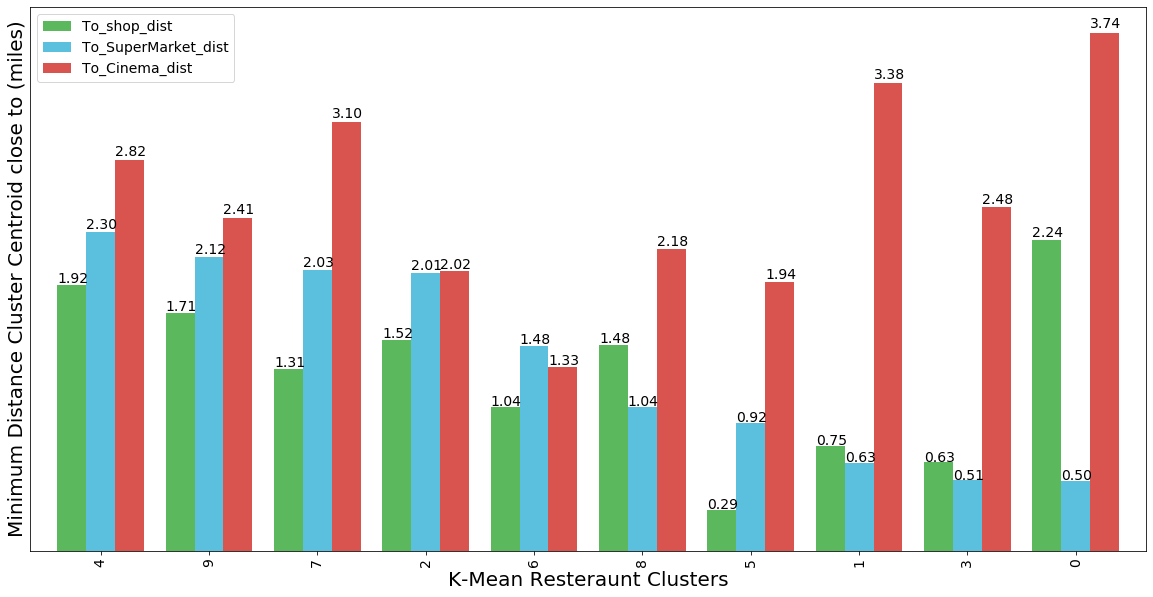

In [22]:
ax = df.iloc[:,1:4].plot(kind = 'bar',
             figsize=(20,10),
             width = 0.8,
             color = ['#5cb85c', '#5bc0de', '#d9534f'],
             fontsize = 14
                 )
ax.get_yaxis().set_ticks([])
plt.xticks(fontsize =14)
plt.legend(fontsize =14)
plt.xlabel('K-Mean Resteraunt Clusters', fontsize = 20)
plt.ylabel('Minimum Distance Cluster Centroid close to (miles)', fontsize = 20)
for p in ax.patches:
    ax.annotate(str(p.get_height())[:4], (p.get_x() * 1.00, p.get_height() * 1.01), fontsize =14)

In [34]:
df_summary = df.describe()
df_summary

,Cluster,To_shop_dist,To_SuperMarket_dist,To_Cinema_dist
count,10.00000,10.000000,10.000000,10.000000
mean,5.50000,1.295941,1.357972,2.544310
std,3.02765,0.610288,0.717208,0.729784
min,1.00000,0.298286,0.508656,1.330073
25%,3.25000,0.828320,0.709160,2.063036
50%,5.50000,1.402927,1.262026,2.449488
75%,7.75000,1.671107,2.028576,3.032687
max,10.00000,2.249473,2.303671,3.746713


### 5. Discussion

Because FourSquare doesn't have enough data of cinema at our designated location, the result of cinema distance have large variances. Howevery, for those cinemas around Cluster "8" and "5", we still consider them as "hubs" for resteraunts. 
From the result, what surprise us is that our hypothsis of Groceries Shop will be "hubs" of resteraunts are preliminary confirmed, as their minimum average distance are within 1.5 miles, very close to a shopping mall distance of 1.3 miles. 